# Modele Bayesowskie

Implementacja narzędzia do wnioskowania przy użyciu sieci Bayesa (algorytm MCMC z próbkowaniem Gibbsa) i jego przykładowe użycie.

## Założenia
1. wnioskowanie będzie stosowało algorytm MCMC z próbkowaniem Gibbsa,
2. metoda/funkcja do wnioskowania będzie mieć 3 parametry wejściowe:
    
    (a) dowody (czyli zaobserwowane wartości wybranych węzłów sieci),
    
    (b) zapytanie — określające, dla której zmiennej chcemy wykonać obliczenia,
    
    (c) liczba iteracji algorytmu MCMC,oraz będzie zwracała zaktualizowaną tabelę prawdopodobieństw dla zmiennej z zapytania,
3. można przyjąć założenie, że wszystkie zmienne losowe są binarne,
4. eksperymenty powinny dotyczyć tego, jak zmieniają się wyniki wnioskowania i czas obliczeńwraz ze zwiększaniem liczby iteracji.


In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import timeit
import time
import seaborn as sns

In [86]:
class BayesNetwork:
    def __init__(self, graph, probs):
        self.graph = graph
        self.probs = probs
        
        self.graph_T = {node: [] for node in self.graph}
        for child, parents in self.graph.items():
            for parent in parents:
                self.graph_T[parent].append(child)
        
    def nodes(self):
        return list(self.graph.keys())
    
    def parents(self, node):
        return self.graph[node]
    
    def children(self, node):
        return self.graph_T[node]
    
    def possible_values(self, node):
        return [False, True]
    
    def sample(self, node, rng):
        return rng.choice(self.possible_values(node))
    
    def _calc_prob(self, node, V):
        '''
        calculate P(node == V[node] | parents(node) == V[parents(node)])
        '''
        val = self.probs[node][tuple(V[p] for p in self.parents(node))]
        if V[node] == 0:
            val = 1 - val
        return val
    
    def gibbs_sample(self, node, V, rng):
        old_val = V[node]
        try:
            vals = []
            for v in self.possible_values(node):
                V[node] = v
                val = self._calc_prob(node, V)
                for child in self.children(node):
                    val *= self._calc_prob(child, V)
                vals.append(val)
                
            vals_sum = sum(vals)
            probs = [v / vals_sum for v in vals]

            return rng.choice(self.possible_values(node), p=probs)
        finally:
            V[node] = old_val

## Algorytm MCMC z próbkowaniem Gibbsa

In [ ]:
def mcmc(G, E, X, iterations, seed=0):
    rng = np.random.RandomState(seed)
    
    V = {
        n: (E[n] if n in E else G.sample(n, rng))
        for n in G.nodes()
    }
    C = {v: 0 for v in G.possible_values(X)}
    
    for _ in range(iterations):
        node = rng.choice(sorted(set(G.nodes()) - set(E.keys())))
        V[node] = G.gibbs_sample(node, V, rng)
        C[V[node]] += 1
        
    return {k: v / iterations for k, v in C.items()}

## Zaimplementowany acykliczny graf alarmu

In [166]:
G = BayesNetwork({
        'wlamanie': [],
        'trzesienie': [],
        'alarm': ['wlamanie', 'trzesienie'],
        'jan': ['alarm'],
        'magda': ['alarm'],
    }, {
        'wlamanie': {(): 0.01},
        'trzesienie': {(): 0.02},
        'alarm': {(True, True): 0.95, (True, False): 0.94,
                  (False, True): 0.29, (False, False): 0.001},
        'jan': {(True,): 0.9, (False,): 0.05},
        'magda': {(True,): 0.7, (False,): 0.01},
    }
)
E = {
    'alarm': True,
    'jan': True,
}
X = 'wlamanie'

In [167]:
%%time
ret = mcmc(G, E, X, 10000)
for val, prob in ret.items():
    print(f'P({X}={val} | {", ".join(f"{k}={v}" for k, v in E.items())}) = {prob}')

P(wlamanie=False | alarm=True, jan=True) = 0.4576
P(wlamanie=True | alarm=True, jan=True) = 0.5424
CPU times: user 423 ms, sys: 19.7 ms, total: 443 ms
Wall time: 428 ms


Przykładowy wynik działania algorytmu, prawdopodobienstwa sumują się do jedynki

## Wykresy oraz wnioski

In [173]:
from collections import defaultdict
import pandas as pd
import seaborn as sns

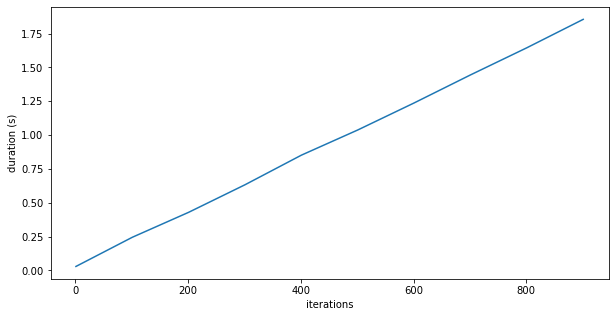

In [188]:
plt.figure(figsize=(10,5))
iterations = list(range(1,1001,100))
durations = []
res = defaultdict(lambda: [])
for iter in iterations:
    durations.append(timeit.timeit(lambda: res[iter].append(mcmc(G, E, X, iter, seed=np.random.randint(0, 10000))[True]), number=50))
plt.plot(iterations, durations)
plt.xlabel('iterations')
plt.ylabel('duration (s)')
plt.show()           

Zależność czasu od iteracji wykonywania przedstawionego algorytmu jest liniowa.

In [179]:
df = pd.DataFrame.from_dict({
    'iteration': [iter for iter, probs in res.items() for prob in probs],
    'true_probability': [prob for iter, probs in res.items() for prob in probs]
})
df

,iteration,true_probability
0,1,1.000000
1,1,1.000000
2,1,1.000000
3,1,1.000000
4,1,1.000000
...,...,...
495,901,0.580466
496,901,0.539401
497,901,0.554939
498,901,0.582686


<AxesSubplot:xlabel='iteration', ylabel='true_probability'>

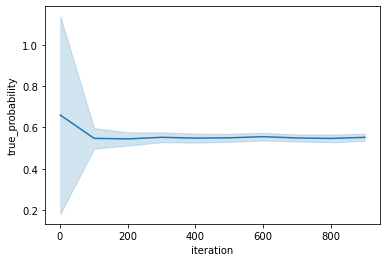

In [180]:
sns.lineplot(df, x='iteration', y='true_probability', errorbar='sd')

Prawdopodobieśtwo zbiega do asymptoty wraz ze wzrostem iteracji, początkowo widać duże odchylenie, które z czasem zanika.

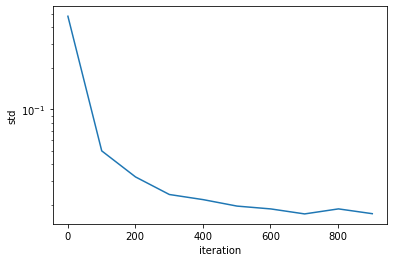

In [184]:
ax = sns.lineplot(df.groupby('iteration', as_index=False).std(), x='iteration', y='true_probability', errorbar='sd')
plt.ylabel('std')
ax.set_yscale('log')

Wraz z wzrostem iteracji algorytmu odchylenie standardowe zmniejsza się.